In [110]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
#from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import glob
from astropy.stats import sigma_clip, median_absolute_deviation

In [3]:
job = Gaia.launch_job_async("select top 10000 * from gaiadr2.vari_cepheid order by source_id")
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


## Adding Uncertanties to Magnitudes

In [227]:
file = 'lcs_3044.txt'
#file = 'lcs_2963.txt'
#file = 'lcs_3173.txt'
#test = 3184429598120069120
#test = 2972082493697861504
test = 3046774762417915136
zp2 = 0.0017850023
lcs = np.loadtxt(file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
source_id = np.loadtxt(file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
band = np.loadtxt(file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
time = lcs[:,0]
mag = lcs[:,1]
flux = lcs[:,2]
flux_error = lcs[:,3]
#Properties of each source
asas_ind = np.argwhere(source_id==test)
asas_mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
asas_time = time[asas_ind[0][0]:asas_ind[-1][0]]
asas_flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
asas_band = band[asas_ind[0][0]:asas_ind[-1][0]]
asas_flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
#Properties of each source seperated by band
G_ind = np.argwhere(asas_band=='G')
time_G = asas_time[G_ind[0][0]:G_ind[-1][0]]
mag_G = asas_mag[G_ind[0][0]:G_ind[-1][0]]
flux_G = asas_flux[G_ind[0][0]:G_ind[-1][0]]
flux_error_G = asas_flux_error[G_ind[0][0]:G_ind[-1][0]]

zp = 25.6883657251
flux_G_conv =  zp - 2.5*np.log10(flux_G)
#flux_error_G_conv = zp - 2.5*np.log10(flux_error_G)
flux_error_G_conv_new = (2.5/np.log(10))*flux_error_G / flux_G

print('Flux_G_Conv = '+str(flux_G_conv[0:4]))
print('Mag_G = '+str(mag_G[0:4]))
#print('Flux_G_Error_Conv = '+str(flux_error_G_conv[0:4]))
print('Flux_G_Error_Conv_New = '+str(flux_error_G_conv_new[0:4]))

Flux_G_Conv = [7.87511002 7.82322958 7.83197085 7.842559  ]
Mag_G = [7.87511002 7.82322958 7.83197085 7.842559  ]
Flux_G_Error_Conv_New = [0.00354217 0.00167998 0.00247539 0.0022268 ]


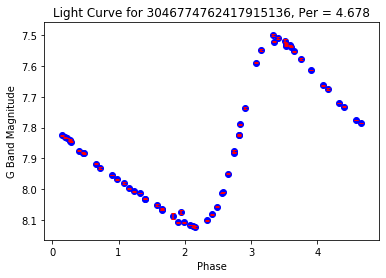

In [215]:
per = r['pf'][np.argwhere(r['source_id']==test)]
per = per[0][0]
phase = time_G % per
flux_error_G_conv = (2.5/np.log(10))*flux_error_G / flux_G
mag_error_G = flux_error_G_conv
#print(flux_error_G)
#print(flux_G)
plt.errorbar(phase, mag_G, yerr=mag_error_G, ls='None', ecolor='r', capsize=2)
plt.scatter(phase, mag_G, c='b')
plt.title('Light Curve for '+str(test)+', Per = '+ str('%.3f'%per))
plt.xlabel('Phase')
plt.ylabel('G Band Magnitude')
plt.gca().invert_yaxis()
plt.show()

## Histogram of Flux Uncertanties

In [69]:
norm = (flux_error_G - np.mean(flux_error_G))/np.std(flux_error_G)
k = np.ceil(np.sqrt(len(flux_error_G)))
#plt.hist(norm, bins=int(k))
#plt.title('Uncertanties in Flux for '+str(test))
#plt.xlabel('Flux - Mean / SD')
#plt.ylabel('Count')
#plt.show()

In [191]:
def Hist(file):
    lcs = np.loadtxt(file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
    source_id = np.loadtxt(file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
    band = np.loadtxt(file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
    time = lcs[:,0]
    mag = lcs[:,1]
    flux = lcs[:,2]
    flux_error = lcs[:,3] 
    ceph_sources = np.loadtxt('vari_cepheids_long.txt', dtype=np.int64)
    norms = []
    for i in range(0, len(ceph_sources)):
        #if ceph_sources[i] != 2936194782069439872:
            #continue
        asas_ind = np.argwhere(source_id==ceph_sources[i])
        if len(asas_ind) == 0:
            continue
        #Properties of each source
        asas_mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
        asas_time = time[asas_ind[0][0]:asas_ind[-1][0]]
        asas_flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
        asas_band = band[asas_ind[0][0]:asas_ind[-1][0]]
        asas_flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
        #Properties of each source seperated by band
        G_ind = np.argwhere(asas_band=='G')
        time_G = asas_time[G_ind[0][0]:G_ind[-1][0]]
        mag_G = asas_mag[G_ind[0][0]:G_ind[-1][0]]
        flux_G = asas_flux[G_ind[0][0]:G_ind[-1][0]]
        flux_error_G = asas_flux_error[G_ind[0][0]:G_ind[-1][0]]
        norm = (flux_error_G - np.median(flux_error_G))/np.std(flux_error_G)
        k = np.ceil(np.sqrt(len(flux_error_G)))
        plt.hist(norm, bins=int(k), edgecolor='black', linewidth=1.2)
        plt.title('Uncertanties in Flux for '+str(ceph_sources[i]))
        plt.xlabel('(Flux - Median)/SD')
        plt.ylabel('Count')
        #plt.savefig('hist_'+str(ceph_sources[i])+'.png', bbox_inches='tight', dpi=300)
        plt.show()
        #norms.append(norm)

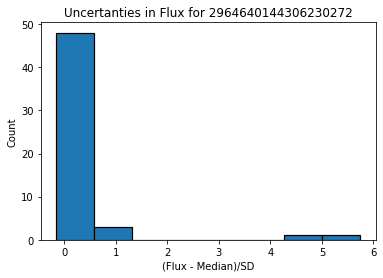

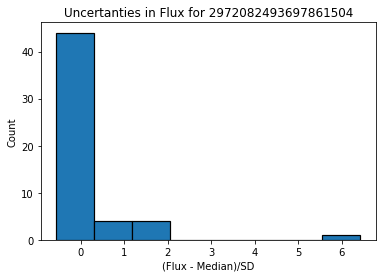

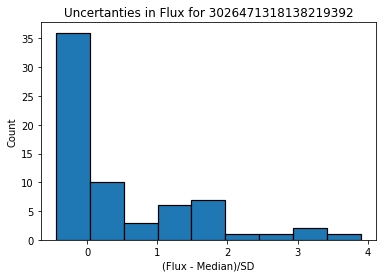

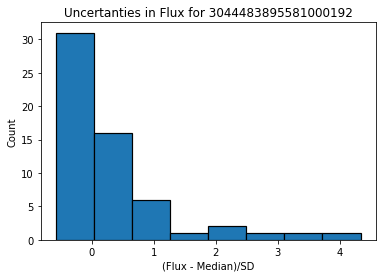

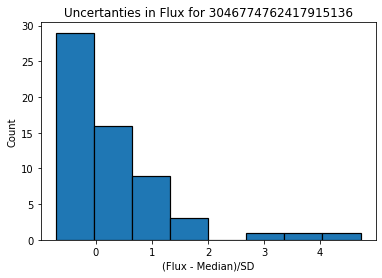

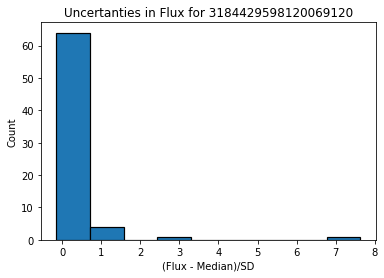

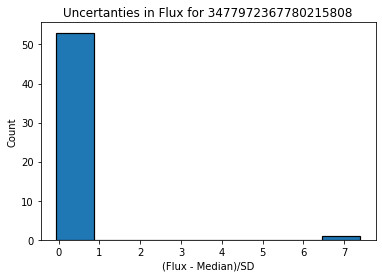

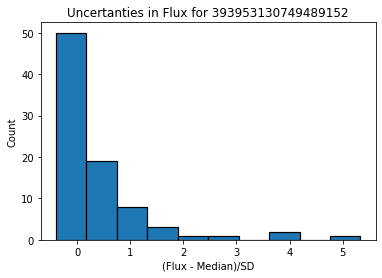

In [192]:
files = glob.glob('lcs_*.txt')
for i in range(0, len(files)):
    Hist(files[i])

## Histogram of Magnitude Uncertanties

## Sigma Clipping

In [198]:
file = 'lcs_3173.txt'
test = 3184429598120069120
lcs = np.loadtxt(file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
source_id = np.loadtxt(file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
band = np.loadtxt(file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
time = lcs[:,0]
mag = lcs[:,1]
flux = lcs[:,2]
flux_error = lcs[:,3]
#Properties of each source
asas_ind = np.argwhere(source_id==test)
asas_mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
asas_time = time[asas_ind[0][0]:asas_ind[-1][0]]
asas_flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
asas_band = band[asas_ind[0][0]:asas_ind[-1][0]]
asas_flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
#Properties of each source seperated by band
G_ind = np.argwhere(asas_band=='G')
time_G = asas_time[G_ind[0][0]:G_ind[-1][0]]
mag_G = asas_mag[G_ind[0][0]:G_ind[-1][0]]
flux_G = asas_flux[G_ind[0][0]:G_ind[-1][0]]
flux_error_G = asas_flux_error[G_ind[0][0]:G_ind[-1][0]]

#print(flux_G)
med = np.median(flux_G)
#mad = median_absolute_deviation(flux_G)
std = np.std(flux_G)
clip = sigma_clip(flux_G, sigma=2, masked=True)
#clip2 = sigma_clip(flux_error_G, sigma=2, masked=True)
print(clip)

[11983.945203495403 12273.382556453726 11633.71884077169
 11535.451312162006 -- -- 12319.06261111768 11346.848187865146
 10987.736239692327 10967.107640419144 10823.41204524031
 10741.983236707465 10674.157035587741 10678.066883662646
 10598.625471389083 10624.796704226008 10675.398455800116
 10631.501853094032 10771.22494163525 10808.890918668014
 10886.977230659008 10935.23540810886 10974.086844348 11163.811062618528
 11276.74839252901 11487.136643339229 11634.08226019028 11802.070695312217
 12111.134088155384 12295.689288173844 12452.560002299493 -- -- -- -- --
 -- -- -- -- -- -- 10833.711778592891 10984.593762647732
 11610.061229480056 11778.07696173325 10311.220508105207 10341.81240594499
 10261.012090205091 10469.79818227514 10602.269882404178 -- -- -- --
 12360.473453248174 11847.414130424699 11729.319827357402
 11141.03711240067 11103.649638109999 10654.75610638822 11647.111383313373
 11307.245464619667 11166.293296912545 -- -- -- -- -- 11700.373483969834]


In [ ]:
for j in range(0,len(asas_flux_G)):
    std = np.std(fitcurve)
    med = np.median(fitcurve)
    if (asas_flux_G[j] < med-2*std) or (asas_flux_G[j] > med+2*std):
        asas_flux_G = np.delete(asas_flux_G, j)
        asas_flux_error_G = np.delete(asas_flux_error_G, j)

## Seven Degree Fourier Fit For Loop

In [225]:
def SevDegFit(file):
    lcs = np.loadtxt(file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
    source_id = np.loadtxt(file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
    band = np.loadtxt(file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
    time = lcs[:,0]
    mag = lcs[:,1]
    flux = lcs[:,2]
    flux_error = lcs[:,3] 
    #flux_over_error = lcs[:,4]
    
    ceph_sources = np.loadtxt('vari_cepheids_long.txt', dtype=np.int64)
    for i in range(0, len(ceph_sources)):
        #if ceph_sources[i] != 3184429598120069120:
            #continue
        asas_ind = np.argwhere(source_id==ceph_sources[i])
        if len(asas_ind) == 0:
            continue
        per = r['pf'][np.argwhere(r['source_id']==ceph_sources[i])]
        per = per[0][0]
        if str(per) == '--':
            continue
        mag_table = r['int_average_g'][np.argwhere(r['source_id']==ceph_sources[i])]
        mag_table = mag_table[0][0]
        #Properties of each source
        asas_mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
        asas_time = time[asas_ind[0][0]:asas_ind[-1][0]]
        asas_flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
        asas_band = band[asas_ind[0][0]:asas_ind[-1][0]]
        asas_flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
        #Properties of each source seperated by band
        G_ind = np.argwhere(asas_band=='G')
        asas_time_G = asas_time[G_ind[0][0]:G_ind[-1][0]]
        asas_mag_G = asas_mag[G_ind[0][0]:G_ind[-1][0]]
        asas_flux_G = asas_flux[G_ind[0][0]:G_ind[-1][0]]
        asas_flux_error_G = asas_flux_error[G_ind[0][0]:G_ind[-1][0]]
        
        #Fit
        myt = asas_time_G % per
        data = asas_flux_G
        #first guesses
        guess_freq = 1
        guess_amp = 3*np.std(data)/(2**0.5)
        guess_offset = np.mean(data)
        p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_offset]
        #create the function we want to fit
        def my_sin(x,freq,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,amp11,amp12,amp13,amp14,offset):
            freq = 1/per
            deg1 = (np.sin(2*np.pi*x*freq)*amp1) + (np.cos(2*np.pi*x*freq)*amp2)
            deg2 = (np.sin(2*np.pi*2*x*freq)*amp3) + (np.cos(2*np.pi*2*x*freq)* amp4)
            deg3 = (np.sin(2*np.pi*3*x*freq)*amp5) + (np.cos(2*np.pi*3*x*freq)* amp6)
            deg4 = (np.sin(2*np.pi*4*x*freq)*amp7) + (np.cos(2*np.pi*4*x*freq)* amp8)
            deg5 = (np.sin(2*np.pi*5*x*freq)*amp9) + (np.cos(2*np.pi*5*x*freq)* amp10)
            deg6 = (np.sin(2*np.pi*6*x*freq)*amp11) + (np.cos(2*np.pi*6*x*freq)* amp12)
            deg7 = (np.sin(2*np.pi*7*x*freq)*amp13) + (np.cos(2*np.pi*7*x*freq)* amp14)
            return offset + deg1 + deg2 + deg3 + deg4 + deg5 + deg6 + deg7
        #now do the fit
        fit = curve_fit(my_sin, myt, data, p0=p0, sigma=asas_flux_error_G)
        
        #repeat for magnitude
        data2 = asas_mag_G
        guess_freq2 = 1
        guess_amp2 = 3*np.std(data2)/(2**0.5)
        guess_offset2 = np.mean(data2)
        p02=[guess_freq2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_offset2]
        
        mag_error_G = (2.5/np.log(10))*asas_flux_error_G / asas_flux_G
        fit2 = curve_fit(my_sin, myt, data2, p0=p02, sigma=mag_error_G)
       
        C_flux = fit[0][-1]
        first_mag = asas_mag_G[0]
        first_flux = asas_flux_G[0]
        conversion = -2.5*np.log10(first_flux)-first_mag 
        
        
        #Sigma-clipping data with respect to fit
        phase = asas_time_G % per
        x = np.linspace(min(phase),max(phase),num=3125)
        fitcurve = my_sin(x, *fit[0])
        std = np.std(fitcurve)
        med = np.median(fitcurve)
        #for j in range(0,(len(asas_flux_G)-1)):
            #if (asas_flux_G[j] < med-2*std) or (asas_flux_G[j] > med+2*std):
                #asas_flux_G = np.delete(asas_flux_G, j)
                #asas_flux_error_G = np.delete(asas_flux_error_G, j)
        fitcurve2 = my_sin(x, *fit2[0])
        #std_mag = np.std(asas_mag_G)
        #std2 = np.std(fitcurve2)
        #med2 = np.med(fitcurve)
        
        #recreate the fitted curve using the optimized parameters
        #Plotting flux
        plt.plot(x, fitcurve, c='r')
        plt.errorbar(phase, asas_flux_G, yerr=asas_flux_error_G, ls='None', ecolor='k', capsize=2)
        plt.scatter(phase, asas_flux_G, c='g')
        plt.title('Light Curve for ' + str(ceph_sources[i]) +', Per = '+ str('%.3f'%per))
        plt.xlabel('Phase')
        plt.ylabel('G Band Flux')
        plt.savefig('LCfit_'+str(ceph_sources[i])+'_deg7_flux_sigma.png', bbox_inches='tight', dpi=300)
        plt.show()
        #Plotting mag
        plt.errorbar(phase, asas_mag_G, yerr=mag_error_G, ls='None', ecolor='green', capsize=2)
        plt.scatter(phase, asas_mag_G, c='b')
        plt.plot(x, fitcurve2, c='r')
        plt.title('Light Curve for ' + str(ceph_sources[i]) +', Per = '+ str('%.3f'%per))
        plt.xlabel('Phase')
        plt.ylabel('Vega Magnitude')
        plt.gca().invert_yaxis()
        plt.savefig('LCfit_'+str(ceph_sources[i])+'_deg7_mag.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        #Stuff to print
        av_mag_mag = np.mean(fitcurve2)
        av_mag_flux = -2.5*np.log10((np.mean(fitcurve)))
        first_mag_flux = -2.5*np.log10((np.mean(first_flux)))
        C_flux_conv = -2.5*np.log10((C_flux))
        C_calc = C_flux_conv - conversion
        print('C_mag = ' + str(fit2[0][-1]))
        print('C_flux = ' + str(fit[0][-1]))
        #print('Conversion = '+str(conversion))
        print('C_flux_converted = ' + str(C_calc))
        print('int_avg_mag = '+str(mag_table))
        #print('STD Flux Fit = '+str(std))

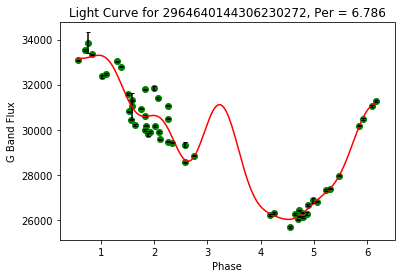

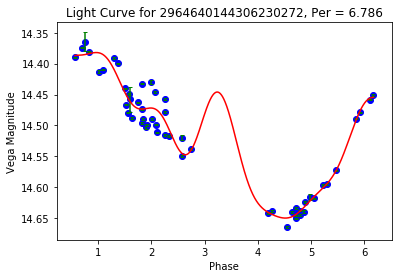

C_mag = 14.503338609089504
C_flux = 29873.476498691376
C_flux_converted = 14.50015130969205
int_avg_mag = 14.508817016968013


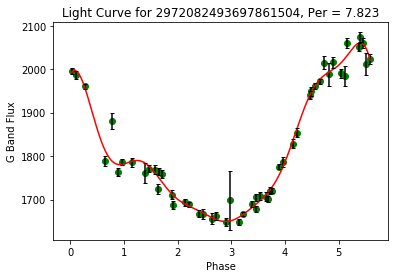

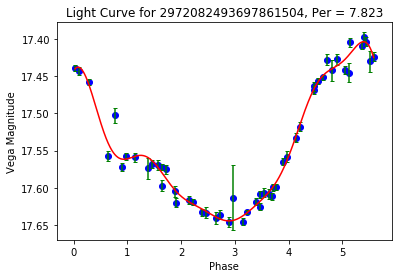

C_mag = 17.621109957533545
C_flux = 1639.88196853788
C_flux_converted = 17.65133424868535
int_avg_mag = 17.505344124281315


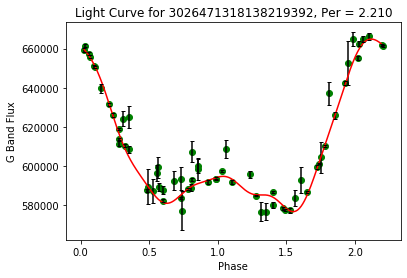

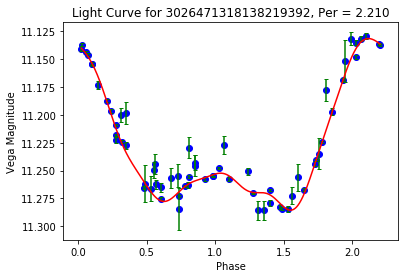

C_mag = 11.230635520322709
C_flux = 607504.7892559078
C_flux_converted = 11.229491460023034
int_avg_mag = 11.23114536272185


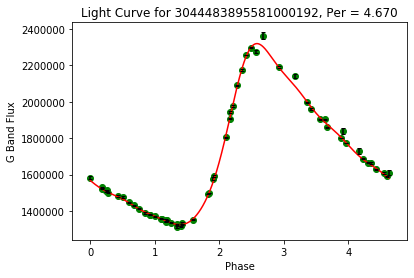

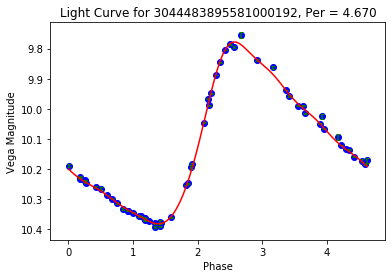

C_mag = 10.112865817010668
C_flux = 1726843.113516783
C_flux_converted = 10.095233517606426
int_avg_mag = 10.08493116189138


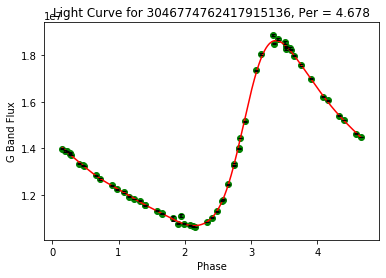

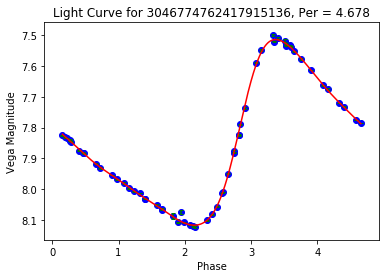

C_mag = 7.846521226358615
C_flux = 13928054.632909011
C_flux_converted = 7.828639571028802
int_avg_mag = 7.830550402788656


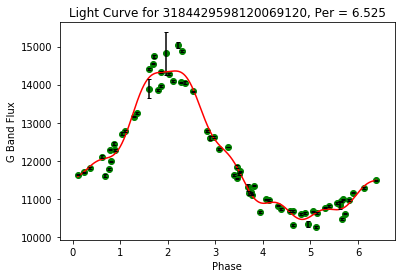

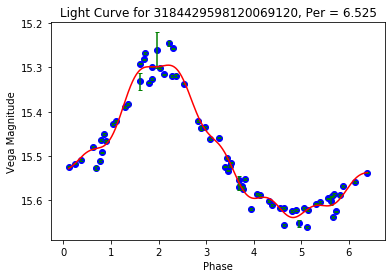

C_mag = 15.492939975086545
C_flux = 12033.845913737938
C_flux_converted = 15.487354609349818
int_avg_mag = 15.487932490847571


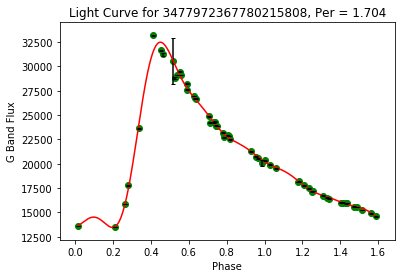

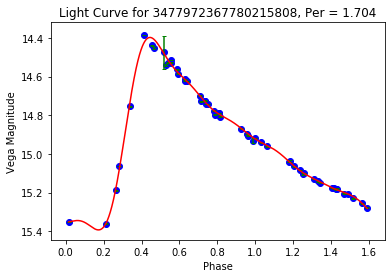

C_mag = 14.97996092808822
C_flux = 19995.150728688128
C_flux_converted = 14.936054019350697
int_avg_mag = 14.949039542984625


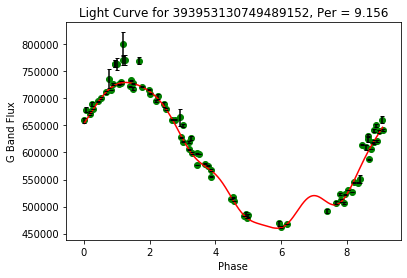

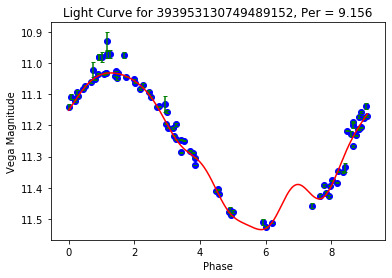

C_mag = 11.28407042238779
C_flux = 584561.6312521686
C_flux_converted = 11.271289959464363
int_avg_mag = 11.28036520478319


In [226]:
files = glob.glob('lcs_*.txt')
for i in range(0, len(files)):
    SevDegFit(files[i])

## Gaia G Band Zero Point ("Conversion Factor") Example

GaiaDR2_ZeroPoints.dat provides "G, G_BP and G_RP zero points used to generate the magnitudes and astrophysical parameters included in Gaia DR2". For the G Band, the unrevised zero point value is 25.6883657251.

In [10]:
fluxy = 1.3344499230519688E7
fluxylog = -2.5*np.log10(fluxy)
magy = 7.875110022692443
fluxylog - magy

-25.688365725119546